Same as kalman.ipynb, but now with particle filter as tracker

In [2]:
import numpy as np

In [3]:
Ts = 0.1
x0, y0 = 10., 10.

# transition matrix
A = np.array([[1, Ts, 0, 0],
              [0,  1, 0, 0],
              [0, 0, 1, Ts],
              [0, 0, 0, 1]])

# input matrix
B = np.array([[0, 0],
              [Ts, 0],
              [0, 0],
              [0, Ts]])

# measurement matrix
C = np.array([[1, 0, 0, 0],
              [0, 0, 1, 0]])

In [4]:
V = 10.0 * np.eye(4) # process noise
W = 10.0 * np.eye(2) # measurement noise (measurements = x and y coords)

In [5]:
N = 400
u = np.zeros((2, N))
u[0, 1] = 100       # at t=0, acceleration right
u[1, 100] = 100     # at t=100*Ts, acceleration up
u[0, 200] = -200    # at t=200*Ts, acceleration left and down
u[1, 200] = -200
u[1, 350] = -300

u[1, 150:170] = 20;

In [6]:
x = np.zeros((4, N)) # matrix of state variables
x[0, 0] = x0; x[1, 0] = 0
x[2, 0] = y0; x[3, 0] = 0

for n in range(1, N-1):
    x[:, n+1] = A @ x[:, n] + B @ u[:, n]

In [7]:
y = C @ x + W @ np.random.standard_normal((2, N))

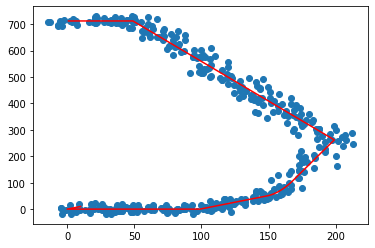

In [8]:
import matplotlib.pyplot as plt

plt.scatter(y[0, :], y[1, :])
plt.plot(x[0, :], x[2, :], 'r')

In [9]:
def particle_filter(n_particles, dim, y, u, A, B, C, V):
    n_steps = y.shape[1]
    particles = init_particles(n_particles, dim, y[:, 0])

    for step in range(n_steps):
        particles = one_step(particles, y[:, step], u[:, step], A, B, C, V)

    return particles

In [10]:
def init_particles(n_particles, dim, y):
    
    particles = np.zeros((dim, n_particles))

    # initialize particles (according to first measurement - this is implicitely p(x0))
    particles[0, :] = y[0]
    particles[2, :] = y[1]

    # add noise to particles
    particles += 10 * np.random.standard_normal((dim, n_particles)) # TODO: how big should this noise be?

    return particles

In [11]:
def one_step(particles, y, u, A, B, C, V):
    n_particles = particles.shape[1]
    # move all particles forward
    for i in range(n_particles):
        particles[:, i] = A @ particles[:, i] + B @ u + V @ np.random.standard_normal(4)
    
    # compute and normalize weights
    weights = 1./np.linalg.norm([C @ p - y for p in particles.T], axis=1)
    weights /= sum(weights)

    # sample new particles from old particles according to weights
    new_indexes = np.random.choice(range(n_particles), size=n_particles, replace=True, p=weights)
    particles = particles[:, new_indexes]

    return particles

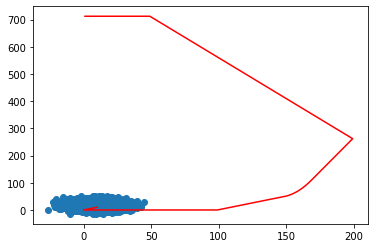

In [16]:
#particles = particle_filter(100, 4, y, A, B, C, V)
particles = init_particles(5000, 4, y[:, 0])
plt.plot(x[0, :], x[2, :], 'r')
plt.scatter(particles[0, :], particles[2, :])

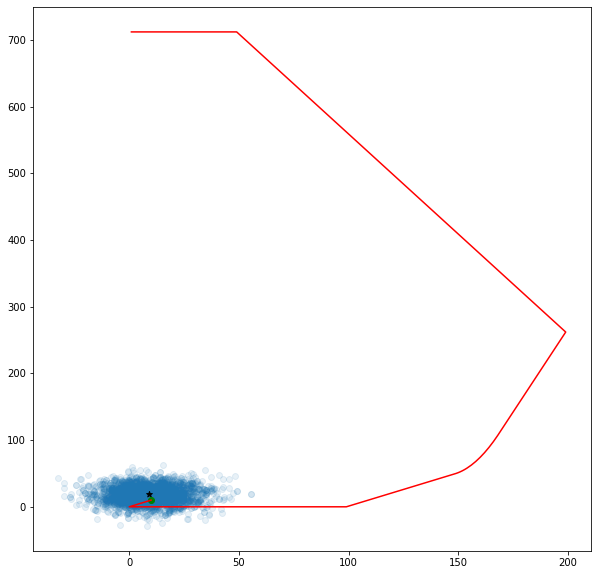

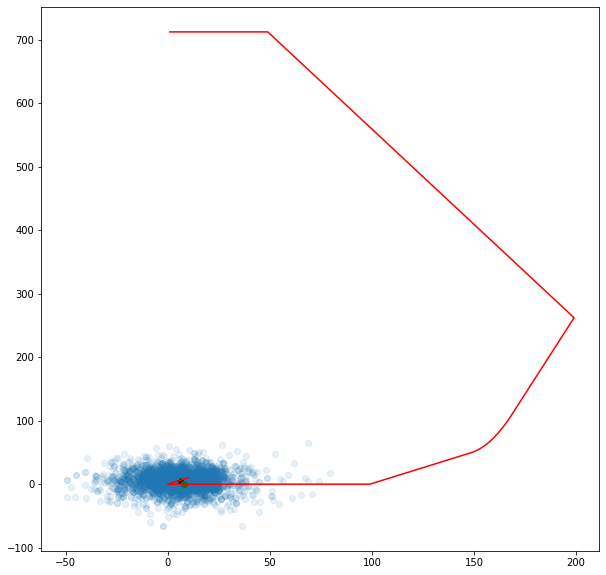

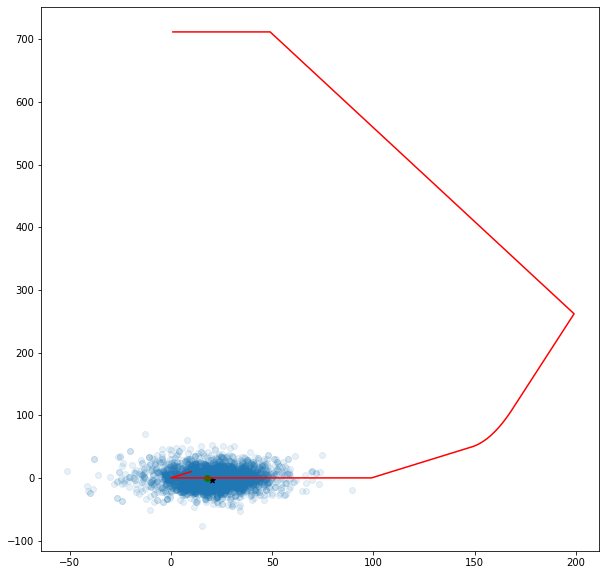

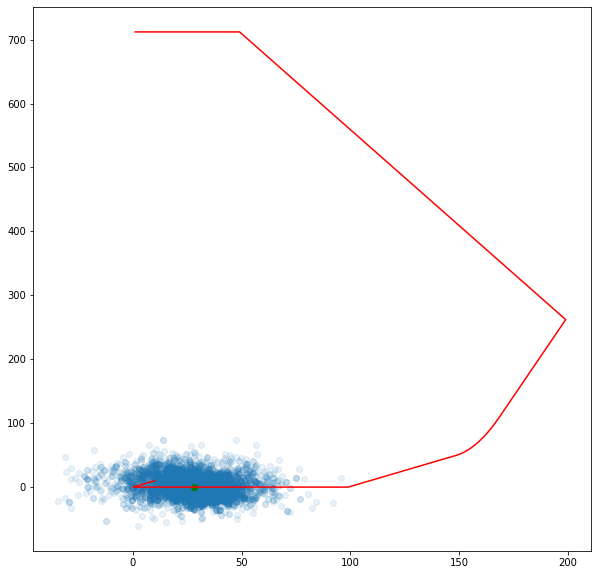

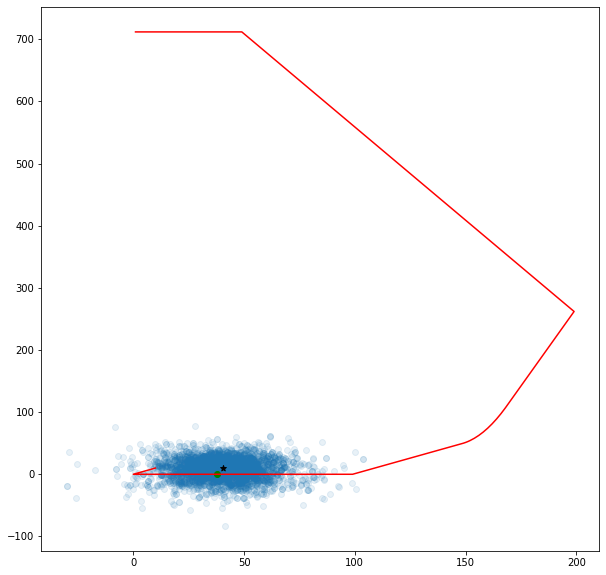

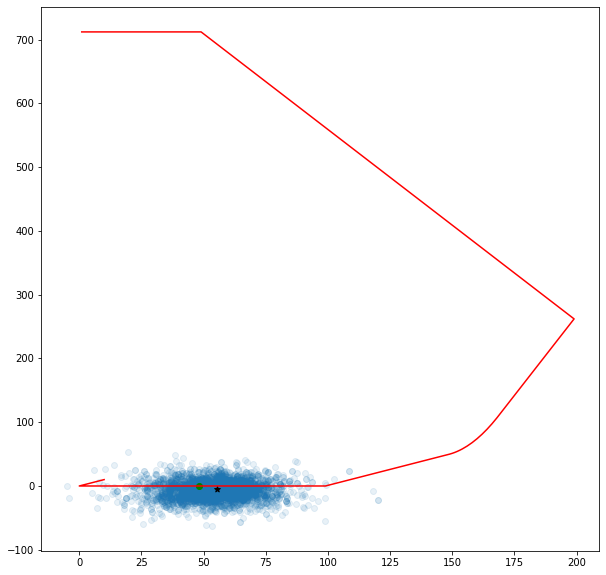

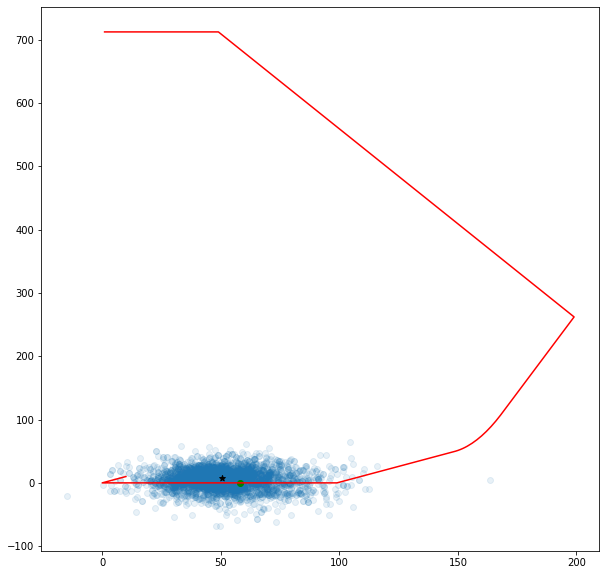

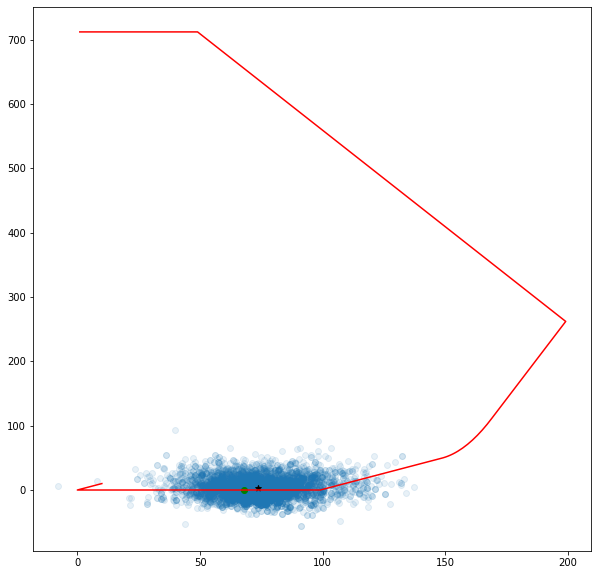

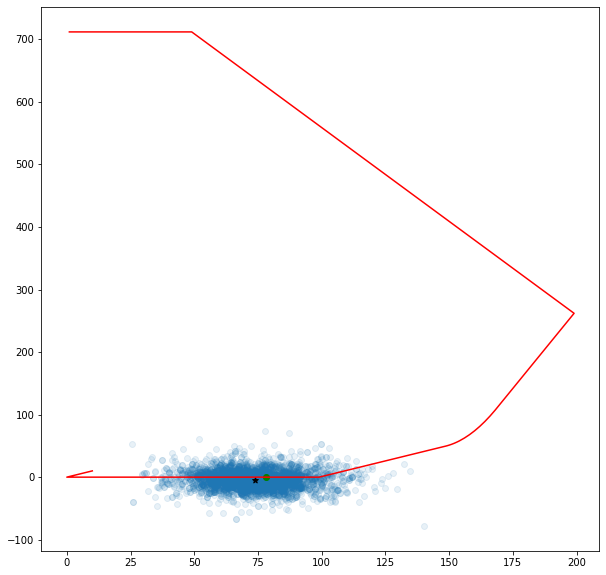

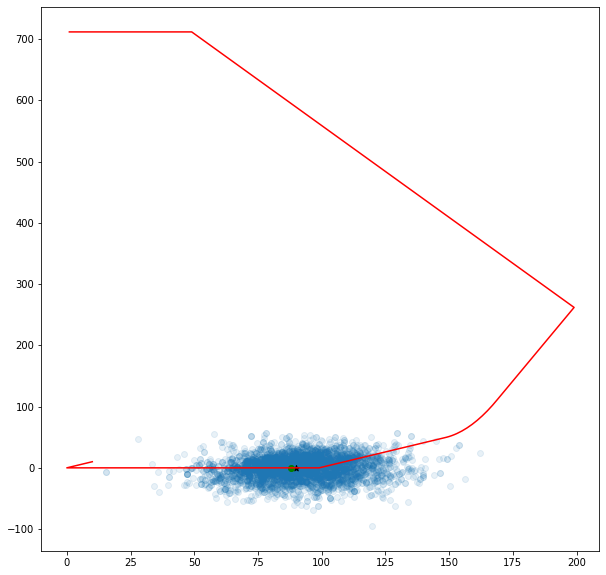

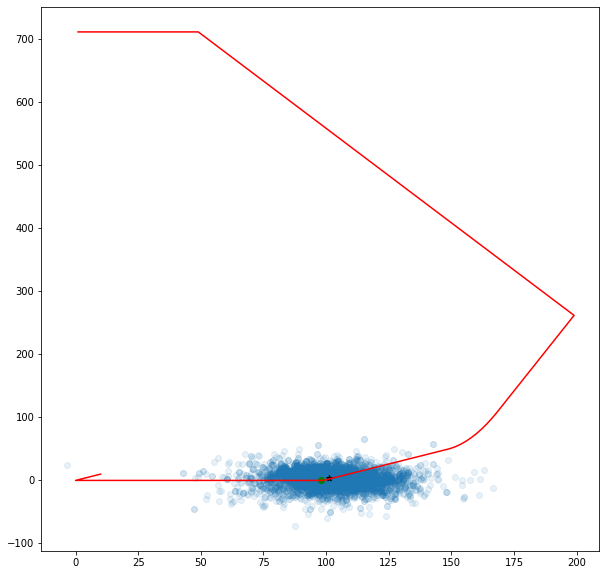

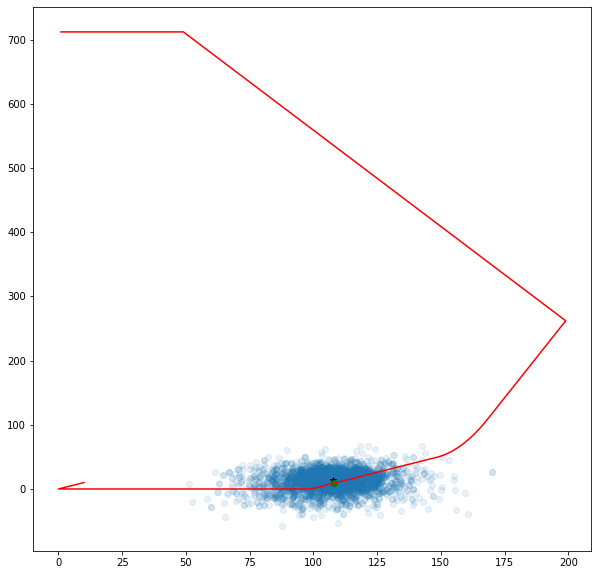

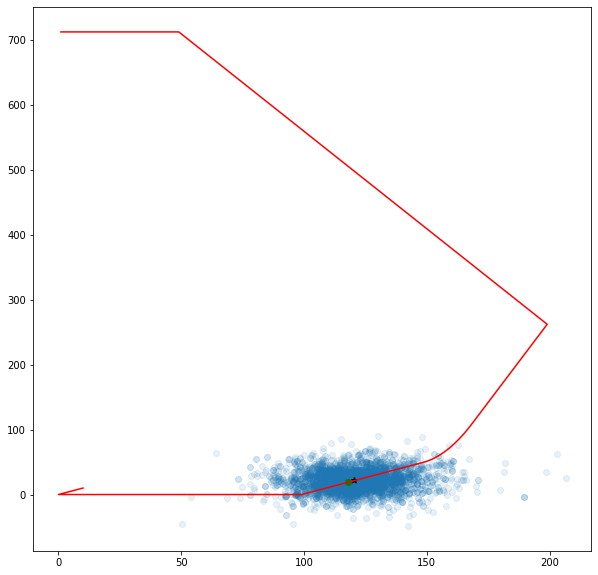

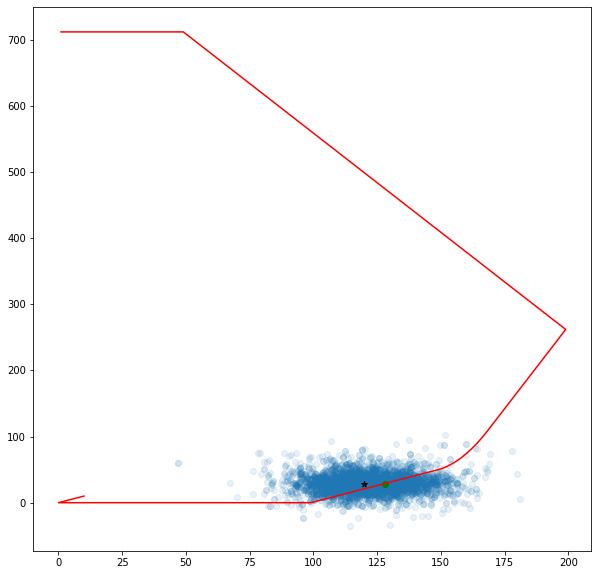

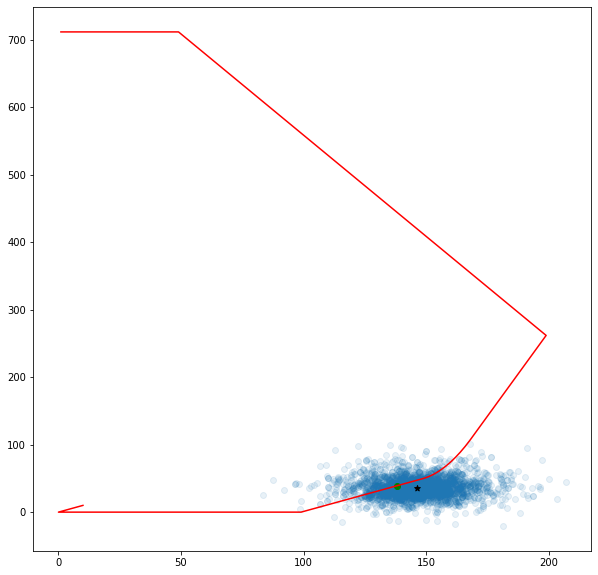

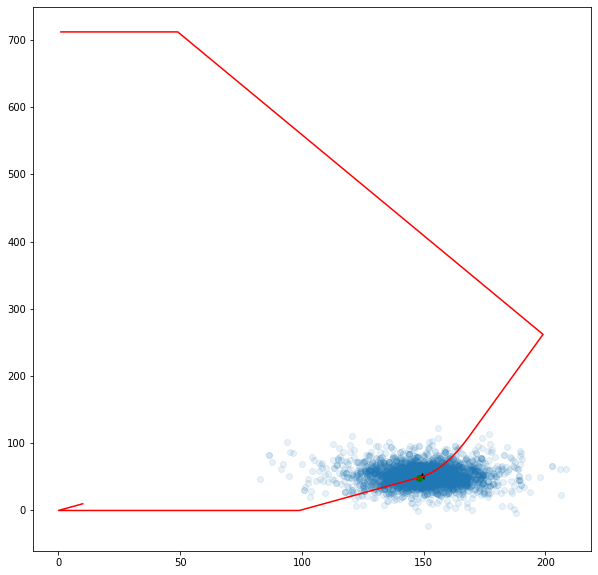

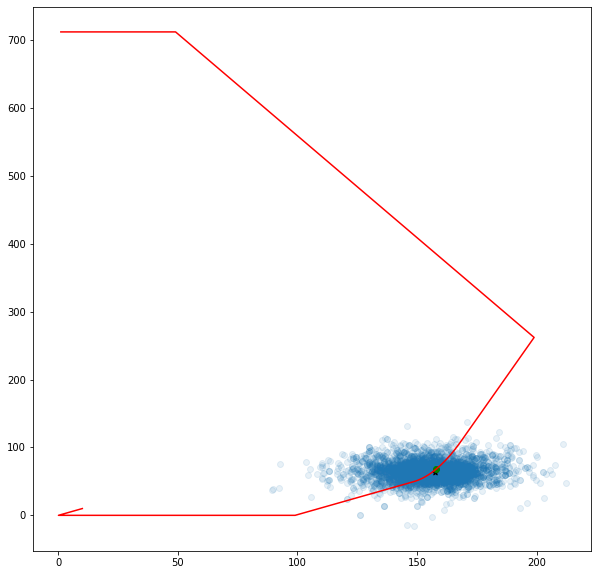

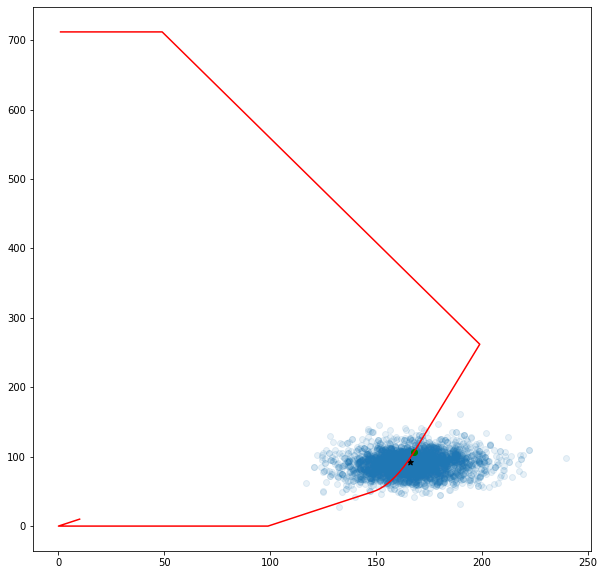

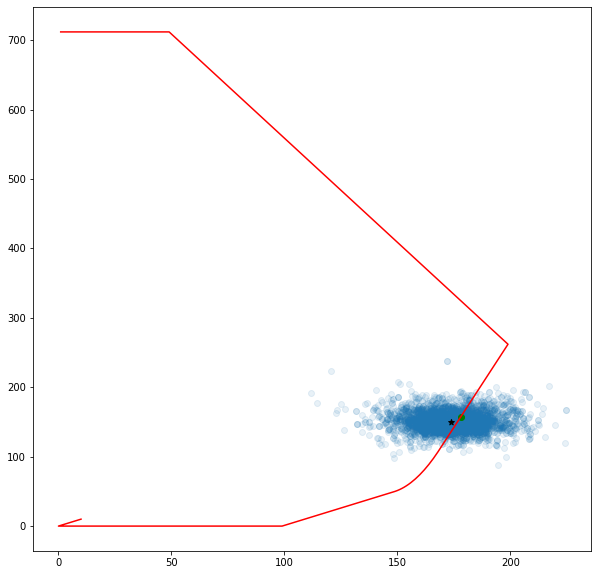

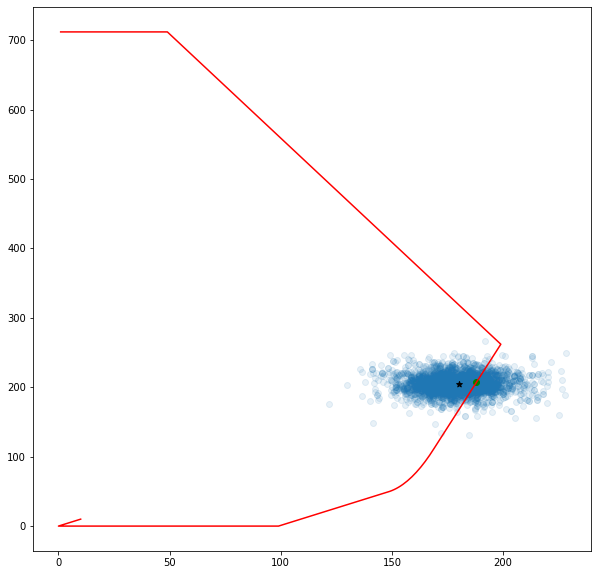

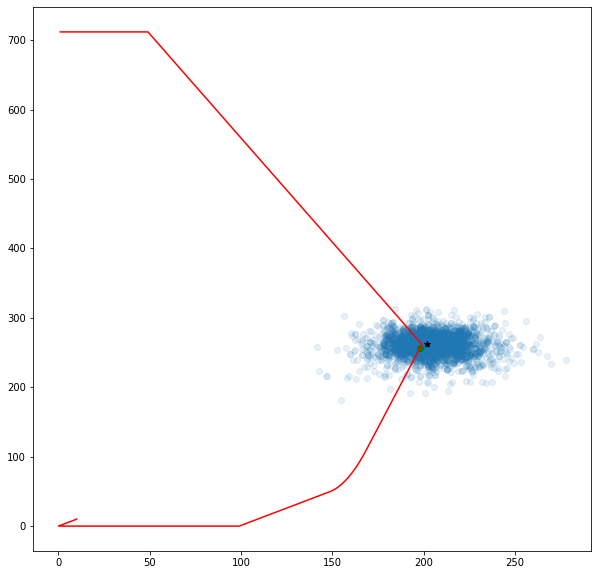

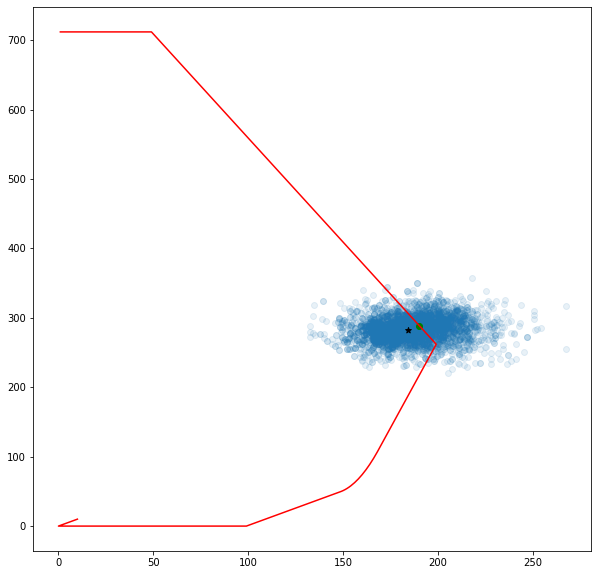

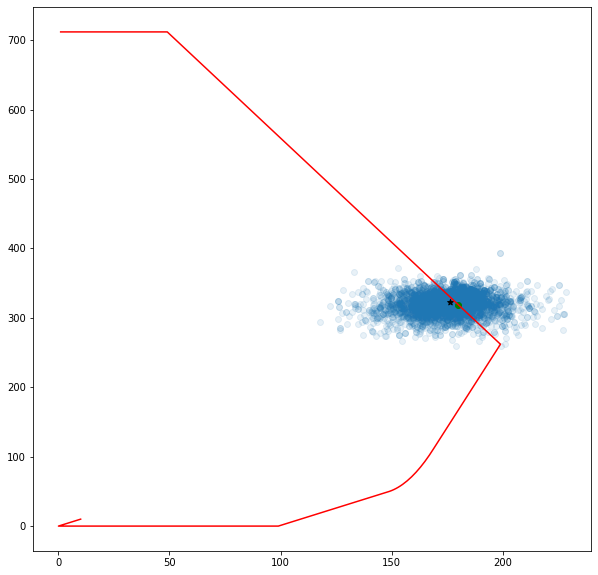

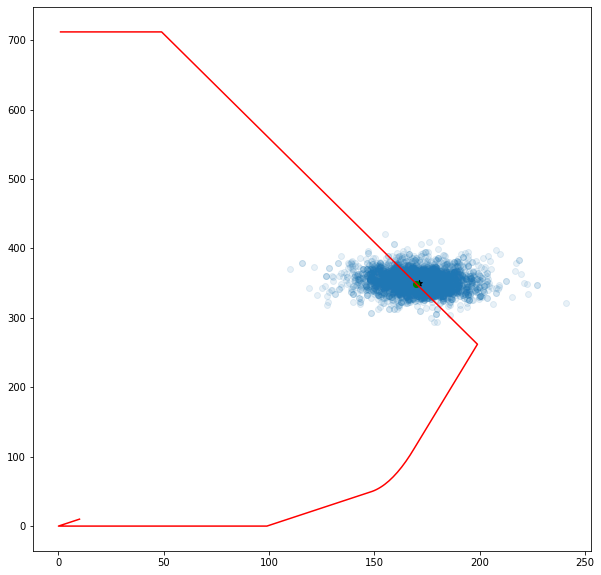

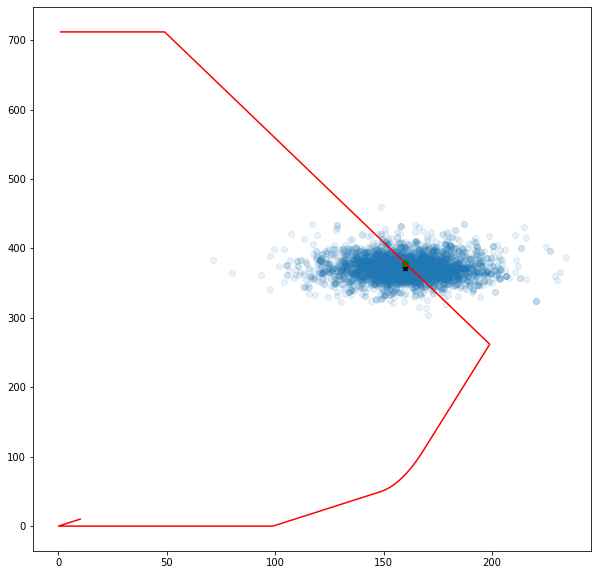

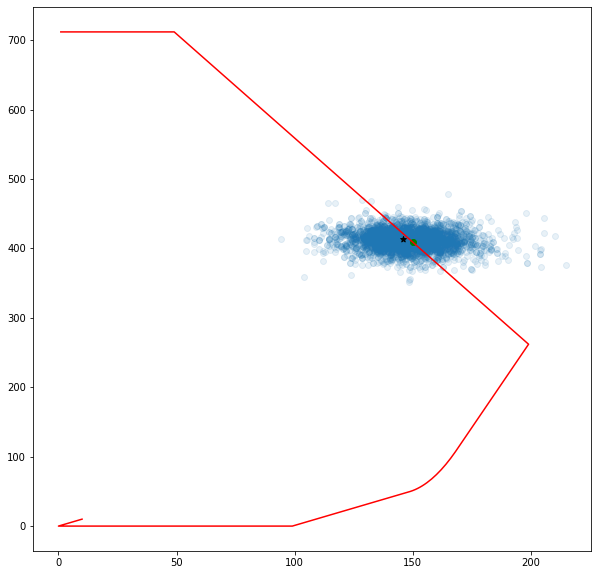

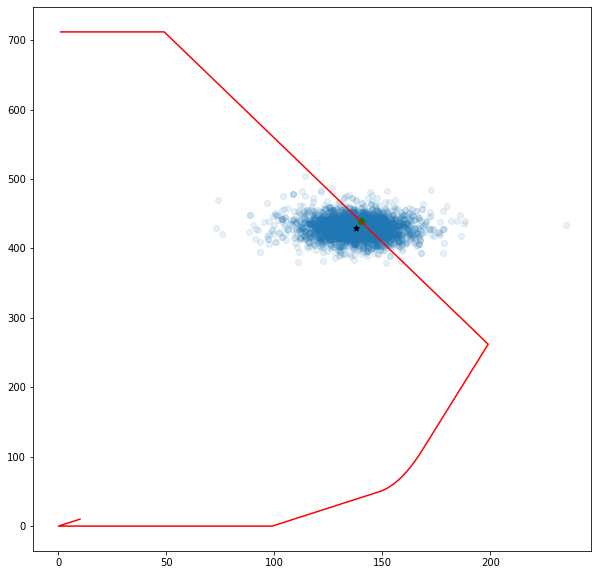

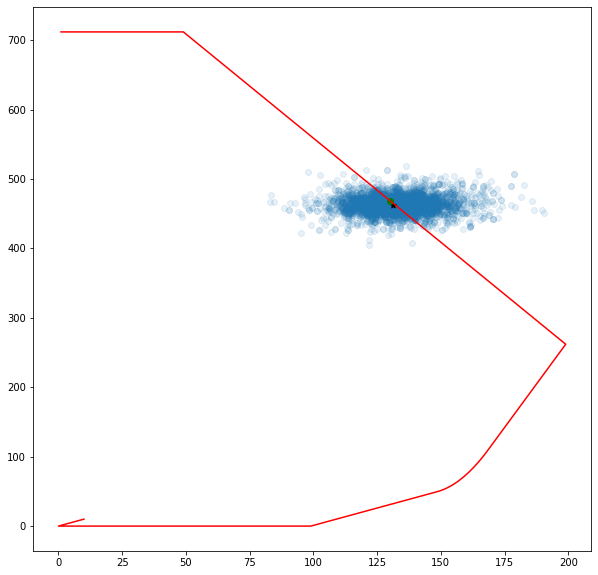

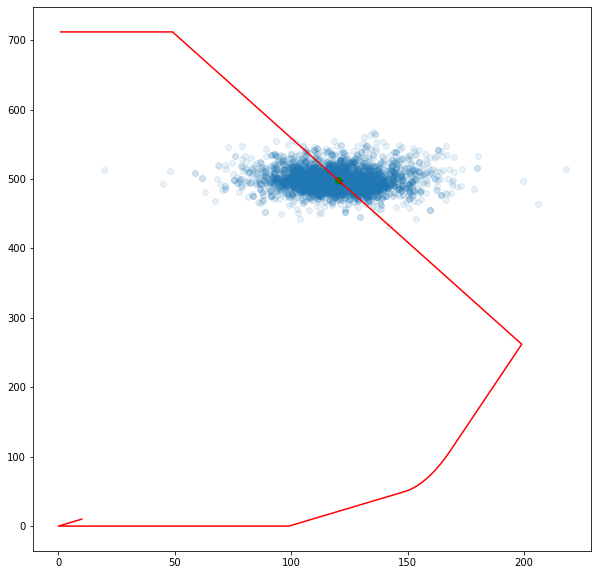

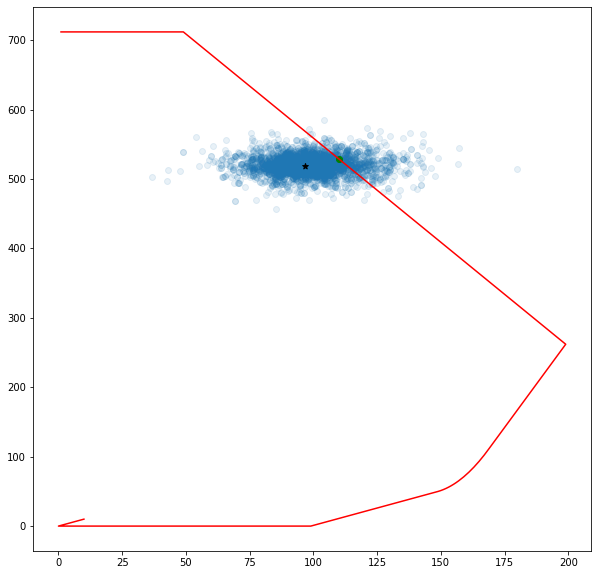

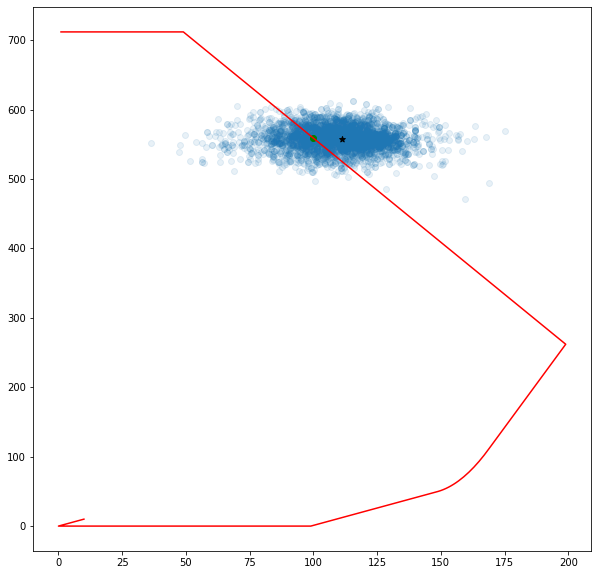

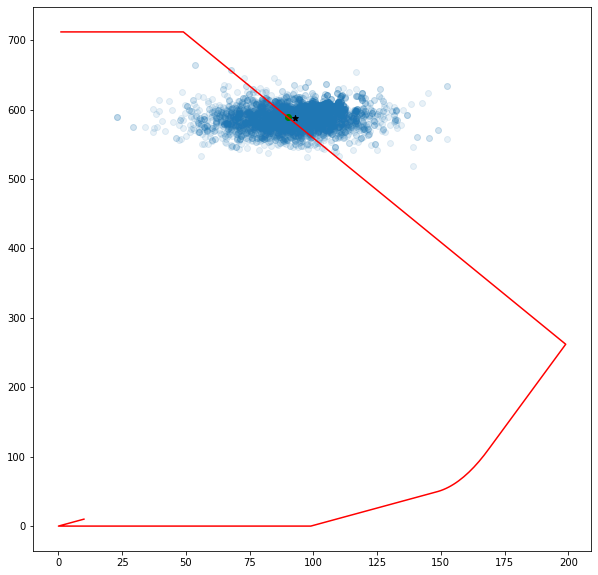

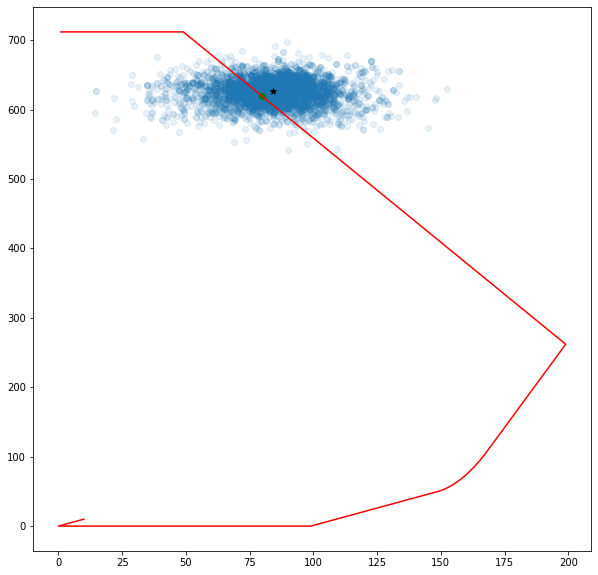

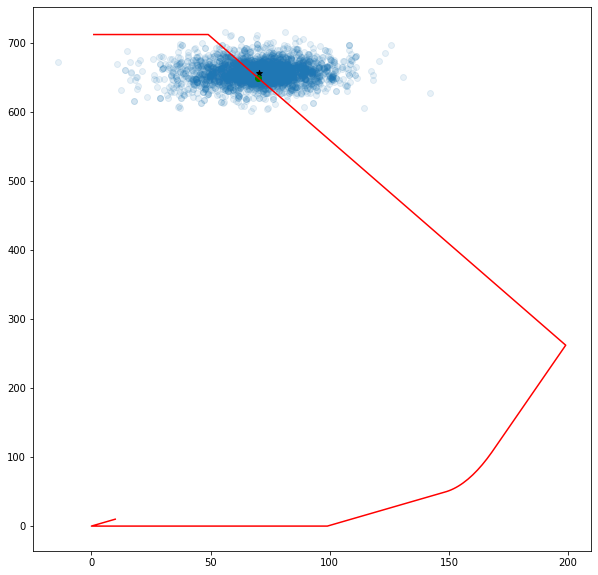

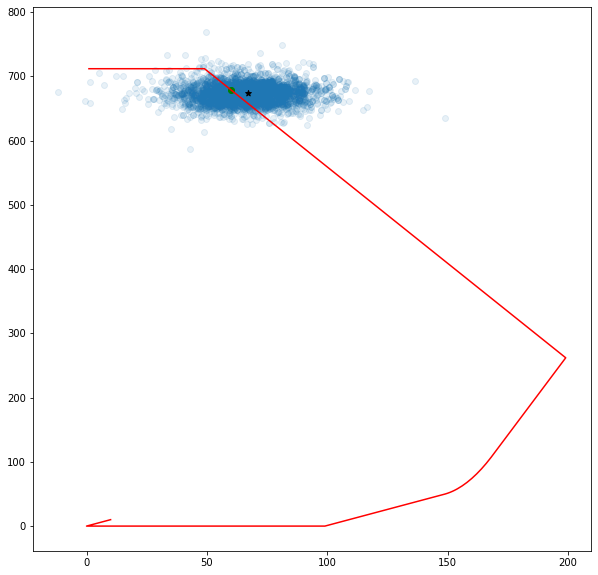

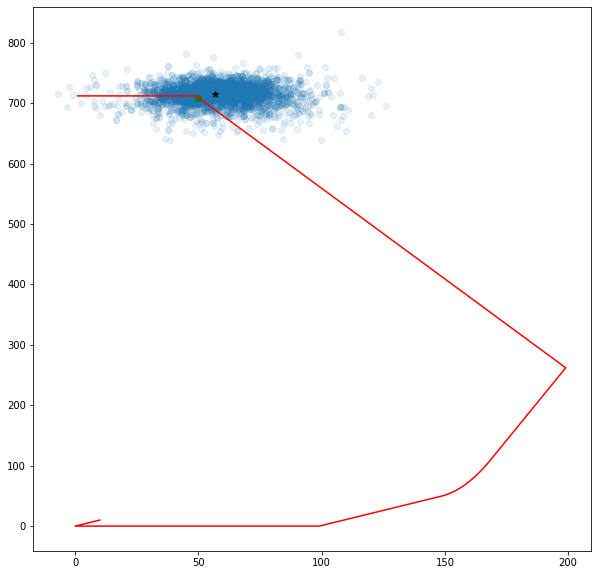

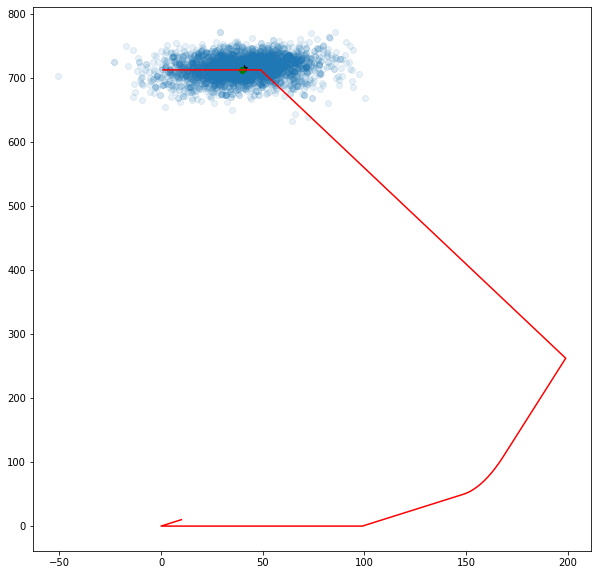

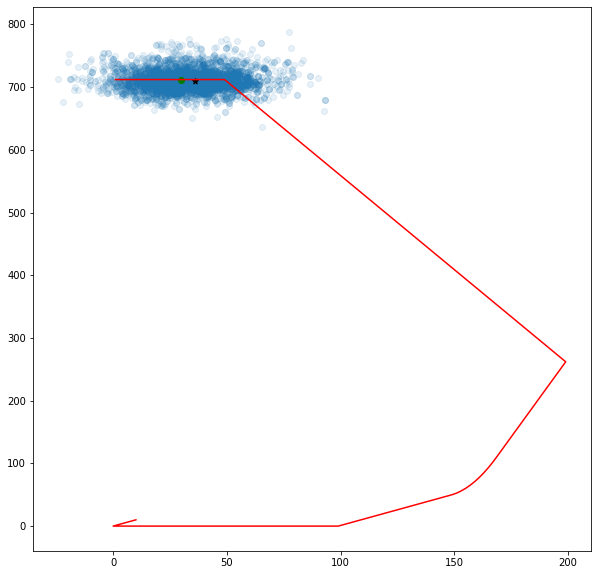

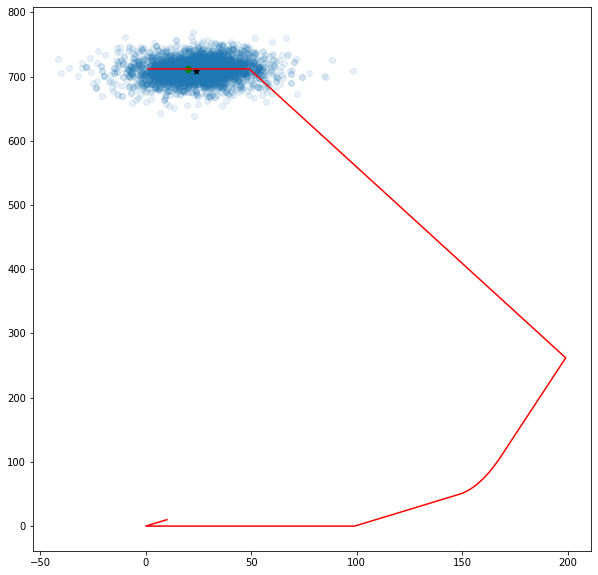

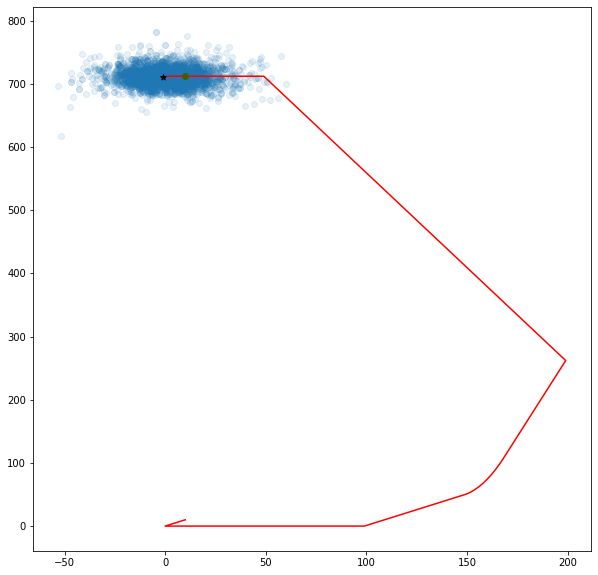

In [17]:
# set input to zero to simulate unknown input
u_ = np.zeros_like(u)
for step in range(y.shape[1]):
    particles = one_step(particles, y[: , step], u[:, step], A, B, C, V)

    if step % 10 == 0:
        plt.figure(figsize=(10, 10))
        plt.title=f"{step}"
        plt.plot(x[0, :], x[2, :], 'r')
        plt.scatter(particles[0, :], particles[2, :], alpha=.1)
        
        particle_mean = np.mean(particles, axis=1)
        plt.scatter(particle_mean[0], particle_mean[2], marker='*', color='k')

        plt.scatter(x[0, step], x[2, step], color='g')
        plt.show()